"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [30]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize as vz

In [75]:
# Some poisson spiking
length = 1000
states = 3
nrns = 5
trials = 15
fit = int(1e5)
samples = 2000

true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

print(true_tau.shape)

state_inds = np.concatenate([np.zeros((trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

print(true_tau.shape)
print(state_inds.shape)

max_p = 0.1
bin_size = 25
true_lambda = np.random.random((nrns,states))*max_p
print(true_lambda.shape)
true_r = np.zeros((trials, nrns, length))

for trial_num in range(trials):
    for state_num in range(states):
        true_r[trial_num,:,state_inds[trial_num,state_num]:state_inds[trial_num,state_num+1]] = \
                        true_lambda[:,state_num][:,np.newaxis]
        
spike_array = np.random.random(true_r.shape) < true_r    
data_array = np.reshape(spike_array, (*spike_array.shape[:2], -1, bin_size)).sum(axis=-1)
idx = np.arange(length//bin_size)

(15, 3)
(15, 2)
(15, 4)
(5, 3)


In [76]:
true_lambda

array([[0.04062288, 0.03830846, 0.088237  ],
       [0.01076944, 0.09993054, 0.00742933],
       [0.08227426, 0.05621708, 0.02228368],
       [0.07421782, 0.02894013, 0.03219367],
       [0.09347262, 0.07121128, 0.00147444]])

In [77]:
data_array.shape

(15, 5, 40)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


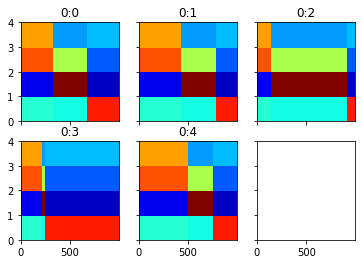

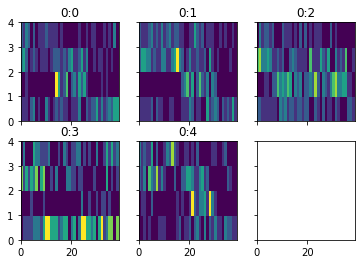

In [78]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials),5)
vz.firing_overview(true_r[trial_inds]);
vz.firing_overview(data_array[trial_inds], cmap='viridis');

In [79]:
# Testval for individual trials
trial_mean = np.array([np.mean(x,axis=-1) for x in np.array_split(data_array,states,axis=-1)]).T
# Testval for states
state_mean = trial_mean.mean(axis=1)
# Testval for neurons
nrn_mean = state_mean.mean(axis=1)
#mean_vals = np.mean(mean_vals,axis=1)
print(mean_vals.shape)

(5, 15, 3)


In [80]:
print(trial_mean.shape)
print(state_mean.shape)
print(nrn_mean.shape)

(5, 15, 3)
(5, 3)
(5,)


In [81]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    nrn_lambda = pm.Exponential('nrn_lambda', 
                                    1/nrn_mean, 
                                    shape = nrns,
                                  testval = nrn_mean + 1e-3)
    state_lambda = pm.Exponential('state_lambda', 
                                    1/nrn_lambda[:,np.newaxis], 
                                    shape = (nrns, states),
                                  testval = state_mean + 1e-3)
    trial_lambda = pm.Exponential('trial_lambda', 
                                    1/state_lambda[:,:,np.newaxis], 
                                    shape = (nrns, states, trials),
                                  testval = trial_mean.swapaxes(1,2) + 1e-3)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((trials,1,length//bin_size)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((trials,1,length//bin_size))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)
    
    lambda_ = tt.tensordot(weight_stack, trial_lambda, [1,1]).sum(axis=-1).dimshuffle(0,2,1)
    
    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=data_array)

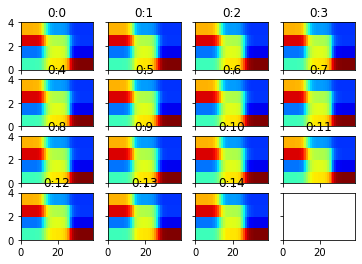

In [82]:
vz.firing_overview(lambda_.tag.test_value);

In [83]:
lambda_.tag.test_value.shape

(15, 5, 40)

In [84]:
data_array.shape

(15, 5, 40)

In [85]:
trial_lambda.tag.test_value.shape

(5, 3, 15)

In [86]:
weight_stack.tag.test_value.shape

(15, 3, 40)

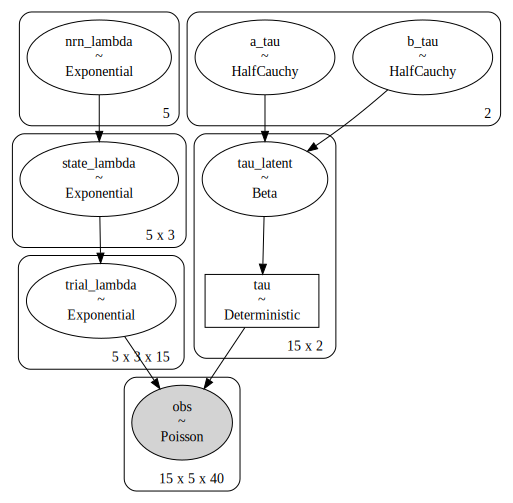

In [87]:
pm.model_to_graphviz(model)

In [88]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

Finished [100%]: Average Loss = 3,956.9


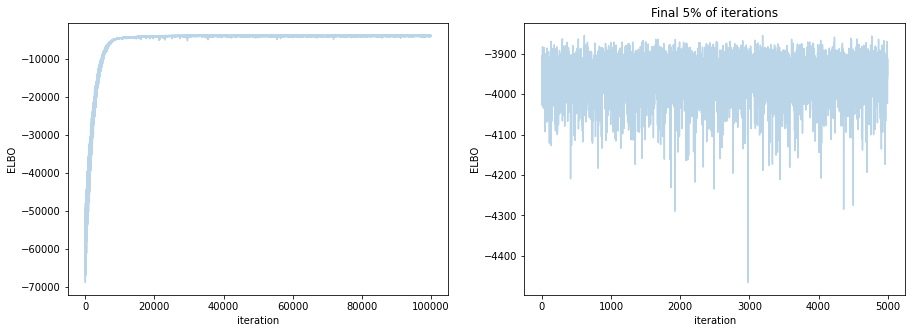

In [89]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [90]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

In [91]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials),5)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


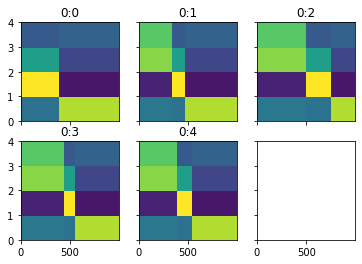

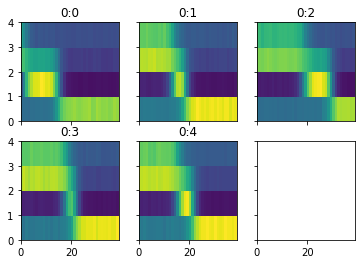

In [92]:
vz.firing_overview(true_r[trial_inds],cmap='viridis');
vz.firing_overview(np.mean(ppc['obs'],axis=0)[trial_inds],cmap='viridis');

In [93]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
print(mode_tau.shape)

(2000, 15, 2)
(15, 2)


In [94]:
mean_lambda = trace['state_lambda'].mean(axis=0)

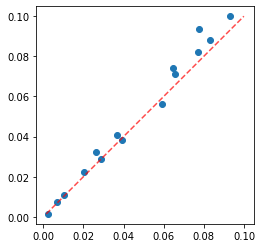

In [95]:
min_val, max_val = true_lambda.min(axis=None), true_lambda.max(axis=None)
x = np.linspace(min_val, max_val)
fig,ax = plt.subplots()
ax.scatter(mean_lambda/2, true_lambda)
ax.set_aspect('equal')
ax.plot(x,x, color = 'red', linestyle = '--', alpha = 0.7)

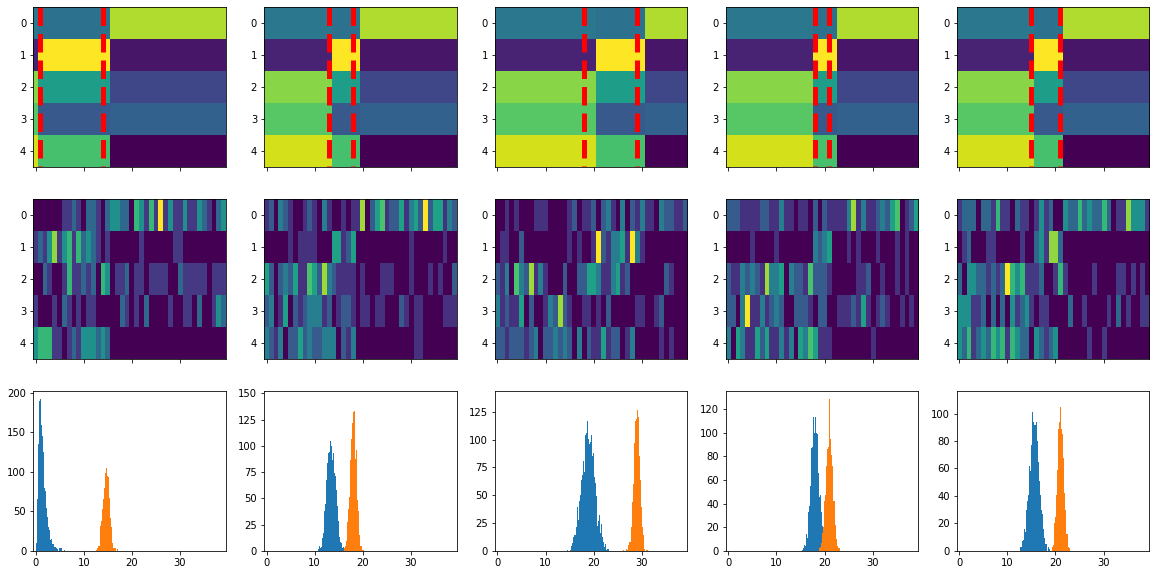

In [96]:
fig,ax = plt.subplots(3,trial_count,sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    ax[0,trial_num].imshow(true_r[this_trial_ind][...,::bin_size],aspect='auto', interpolation='nearest')
    ax[1,trial_num].imshow(data_array[this_trial_ind],aspect='auto', interpolation='nearest')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')